In [3]:
import string
import re
import random
import time
import math
import os

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from nltk.tokenize import word_tokenize

In [127]:
USE_CUDA = True

In [174]:
# SOS_token = 0
# EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {}
        self.n_words = 0
    
    def index_words(self, sentence):
        for word in word_tokenize(sentence.lower()):
            self.index_word(word)
    
    def index_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1  
            
    def filterRareWords(self, vocabularySize = 8000):
        sorted_words = sorted(list(self.word2count.items()), 
                              key = lambda x: -x[1])
        most_frequent_words = [w for (w, c) in sorted_words[:vocabularySize]]
        self.word2index = {w: (index + 1) for (index, w) in enumerate(most_frequent_words)}
        self.word2index["[EOS]"] = 0
        self.word2index["[SOS]"] = len(self.word2index)
        self.word2index["[UNK]"] = len(self.word2index)
        self.index2word = {index: w for (w, index) in self.word2index.items()}
        self.vocabulary = {'word2id': self.word2index, 'id2word': self.index2word}

In [175]:
def normalize_string(s):
    s = re.sub(r"([.!?])", r"\1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    
    return s

In [176]:
def readArticle(fileName):
#     print("reading articles...")
    
    f = open(fileName)
    rawLine = f.readline()
    rawLine = normalize_string(rawLine).strip()
    
    f.close()
    return rawLine

In [177]:
def readCaption(fileName):
#     print("reading captions...")
    
    f = open(fileName)
    rawLine = f.readline()
    rawLine = normalize_string(rawLine).strip()
    
    f.close()
    return rawLine

In [178]:
def readArticleCaptionPairs(articleDirName, captionDirName):
    pairs = []
    
    for fileName in os.listdir(articleDirName):
        if fileName.endswith(".txt"):
            articleFileName = os.path.join(articleDirName, fileName)
            captionFileName = os.path.join(captionDirName, fileName)
            if not os.path.isfile(captionFileName):
                continue
            articleContent = readArticle(articleFileName)
            captionContent = readCaption(captionFileName)
            
            articleCaptionPair = (articleContent, captionContent)
            pairs.append(articleCaptionPair)
            
    return pairs

In [179]:
def prepareData(articleCaptionLang, articleDirName, captionDirName):
    
    pairs = readArticleCaptionPairs(articleDirName, captionDirName)
    
    for pair in pairs:
        articleCaptionLang.index_words(pair[0])
        articleCaptionLang.index_words(pair[1])
    
#     articleCaptionLang.filterRareWords()
    return pairs

In [180]:
def visualizeWordDistribution(articleCaptionLang):
    sorted_words = sorted(list(articleCaptionLang.word2count.items()), 
                              key = lambda x: -x[1])
    totalVocSize = len(sorted_words)
    print("totalVocSize\t", totalVocSize)
    xList = []
    yList = []
    
    for wordIndex in range(totalVocSize):
#         print(wordIndex)
        xList.append(wordIndex)
        yList.append(articleCaptionLang.word2count[sorted_words[wordIndex][0]])
    
    print(np.mean(yList))
    print(yList[8000])
    plt.plot(xList, yList)
    plt.show()
    
#     for word in sorted_words:
#         xList.append()
#     most_frequent_words = [w for (w, c) in sorted_words]
    

In [181]:
articleCaptionLang = Lang("articleCaption")

In [137]:
# visualizeWordDistribution(articleCaptionLang)

In [182]:
articleCaptionLang.filterRareWords()

In [183]:
articleDirName = "./IND-articles"

In [184]:
captionDirName = "./IND-captions"

In [185]:
pairs=prepareData(articleCaptionLang, articleDirName, captionDirName)

In [186]:
print(random.choice(pairs))

('Threats to the future of the Department for Business are nothing new. Back in Vince Cable proposed abolishing the old Department for Trade and Industry because it doesn t perform a function . Happily Mr Cable had cooled on the idea by the time he was made Secretary of State for Business Innovation and Skills BIS for the Coalition in . But the rumours are back in the wake of last week s Tory election triumph. Adrian Bailey the chair of the BIS Commons Select Committee in the last Parliament believes David Cameron s Government s plans for some bn of Whitehall cuts could eventually mean BIS led by Sajid Javid after yesterday s reshuffle will be abolished and its responsibilities distributed across Whitehall. The Taxpayers Alliance lobby group recently estimated that closing and parcelling out the functions of BIS along with Energy and Culture to other departments could save . bn over five years. The Tory backbencher Dominic Raab is one of those who have lobbied for the end of BIS in rec

In [187]:
MAX_LENGTH = 400

In [188]:
def indexes_from_sentence(lang, sentence):
    ids = []
    for w in word_tokenize(sentence.lower()):
        if w not in lang.word2index.keys():
            ids.append(lang.word2index['[UNK]'])
        else:
            ids.append(lang.word2index[w])
            
    ids.insert(0, lang.word2index['[SOS]'])
    ids.append(lang.word2index['[EOS]'])

    return ids

def variable_from_sentence(lang, sentence):
    indexes = indexes_from_sentence(lang, sentence)
    var = Variable(torch.LongTensor(indexes).view(-1, 1))
#     print('var =', var)
    if USE_CUDA: var = var.cuda()
    return var

def variables_from_pair(articleCaptionLang, pair):
    input_variable = variable_from_sentence(articleCaptionLang, pair[0])
    target_variable = variable_from_sentence(articleCaptionLang, pair[1])
    return (input_variable, target_variable)

In [189]:
training_pair = variables_from_pair(articleCaptionLang, random.choice(pairs))

In [190]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(EncoderRNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_size, hidden_size)
       
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        
    def forward(self, word_inputs, hidden):
        # Note: we run this all at once (over the whole input sequence)
        seq_len = len(word_inputs)
        embedded = self.embedding(word_inputs).view(seq_len, 1, -1)
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

    def init_hidden(self):
        hidden = Variable(torch.zeros(self.n_layers, 1, self.hidden_size))
        if USE_CUDA: hidden = hidden.cuda()
        return hidden

In [191]:
class Attn(nn.Module):
    def __init__(self, method, hidden_size, max_length=MAX_LENGTH):
        super(Attn, self).__init__()
        
        self.method = method
        self.hidden_size = hidden_size
        
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)

        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.other = nn.Parameter(torch.FloatTensor(1, hidden_size))

    def forward(self, hidden, encoder_outputs):
        seq_len = len(encoder_outputs)

        # Create variable to store attention energies
        attn_energies = Variable(torch.zeros(seq_len)) # B x 1 x S
        if USE_CUDA: attn_energies = attn_energies.cuda()

        # Calculate energies for each encoder output
        for i in range(seq_len):
            attn_energies[i] = self.score(hidden, encoder_outputs[i])

        # Normalize energies to weights in range 0 to 1, resize to 1 x 1 x seq_len
        return F.softmax(attn_energies).unsqueeze(0).unsqueeze(0)
    
    def score(self, hidden, encoder_output):
        
        if self.method == 'dot':
            energy = hidden.dot(encoder_output)
            return energy
        
        elif self.method == 'general':
            energy = self.attn(encoder_output)
            energy = hidden.dot(energy)
            return energy
        
        elif self.method == 'concat':
            energy = self.attn(torch.cat((hidden, encoder_output), 1))
            energy = self.other.dot(energy)
            return energy

In [192]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, hidden_size, output_size, n_layers=1, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        
        # Keep parameters for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        
        # Define layers
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size * 2, hidden_size, n_layers, dropout=dropout_p)
        self.out = nn.Linear(hidden_size * 2, output_size)
        
        # Choose attention model
        if attn_model != 'none':
            self.attn = Attn(attn_model, hidden_size)
    
    def forward(self, word_input, last_context, last_hidden, encoder_outputs):
        # Note: we run this one step at a time
        
        # Get the embedding of the current input word (last output word)
        word_embedded = self.embedding(word_input).view(1, 1, -1) # S=1 x B x N
        
        # Combine embedded input word and last context, run through RNN
        rnn_input = torch.cat((word_embedded, last_context.unsqueeze(0)), 2)
        rnn_output, hidden = self.gru(rnn_input, last_hidden)

        # Calculate attention from current RNN state and all encoder outputs; apply to encoder outputs
        attn_weights = self.attn(rnn_output.squeeze(0), encoder_outputs)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1)) # B x 1 x N
        
        # Final output layer (next word prediction) using the RNN hidden state and context vector
        rnn_output = rnn_output.squeeze(0) # S=1 x B x N -> B x N
        context = context.squeeze(1)       # B x S=1 x N -> B x N
        output = F.log_softmax(self.out(torch.cat((rnn_output, context), 1)))
        
        # Return final output, hidden state, and attention weights (for visualization)
        return output, context, hidden, attn_weights

In [193]:
teacher_forcing_ratio = 0.5
clip = 5.0

def train(articleCaptionLang, input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    # Zero gradients of both optimizers
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0 # Added onto for each word
    
     # Get size of input and target sentences
    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]
    
    # Run words through encoder
    encoder_hidden = encoder.init_hidden()
    encoder_outputs, encoder_hidden = encoder(input_variable, encoder_hidden)
    
    decoder_input = Variable(torch.LongTensor([[articleCaptionLang.word2index['[SOS]']]]))
    decoder_context = Variable(torch.zeros(1, decoder.hidden_size))
    decoder_hidden = encoder_hidden
    if USE_CUDA:
        decoder_input = decoder_input.cuda()
        decoder_context = decoder_context.cuda()
        
    use_teacher_forcing = random.random() < teacher_forcing_ratio
    if use_teacher_forcing:
        for di in range(target_length):
            decoder_output, decoder_context, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_context, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output[0], target_variable[di])
            decoder_input = target_variable[di]
    else:
        for di in range(target_length):
            decoder_output, decoder_context, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_context, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output[0], target_variable[di])
            
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]
            
            decoder_input = Variable(torch.LongTensor([[ni]]))
            if USE_CUDA: decoder_input = decoder_input.cuda()
                
            if ni==articleCaptionLang.word2index['[EOS]']:
                break
                
    loss.backward()
    torch.nn.utils.clip_grad_norm(encoder.parameters(), clip)
    torch.nn.utils.clip_grad_norm(decoder.parameters(), clip)
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.data[0]/target_length

In [194]:
def as_minutes(s):
    m = math.floor(s/60)
    s -= m*60
    return "%dm %ds"%(m, s)

def time_since(since, percent):
    now = time.time()
    s = now-since
    es = s/percent
    rs = es - s
    
    return "%s (-%s)"%(as_minutes(s), as_minutes(rs))

In [195]:
attn_model = "general"
hidden_size = 500
n_layers = 2
dropout_p = 0.05

encoder = EncoderRNN(articleCaptionLang.n_words, hidden_size, n_layers)
decoder = AttnDecoderRNN(attn_model, hidden_size, articleCaptionLang.n_words, n_layers, dropout_p=dropout_p)

if USE_CUDA:
    encoder.cuda()
    decoder.cuda()
    
learning_rate = 0.0001
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)

criterion = nn.NLLLoss()

In [ ]:
n_epochs = 50000
plot_every = 800
print_every = 400

start = time.time()
plot_losses = []
print_loss_total = 0
plot_loss_total = 0

In [ ]:
for epoch in range(1, n_epochs+1):
    training_pair = variables_from_pair(articleCaptionLang, random.choice(pairs))
    input_variable = training_pair[0]
    target_variable = training_pair[1]
    
    loss = train(articleCaptionLang, input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
    
    print_loss_total += loss
    plot_loss_total += loss
    
    if epoch == 0:continue
        
    if epoch%print_every == 0:
        print_loss_avg = print_loss_total /print_every
        print_loss_total = 0
        print_summary = "%s (%d %d %%) %.4f"%(time_since(start, epoch/n_epochs), epoch, epoch/n_epochs*100, print_loss_avg)
        print(print_summary)
        
    if epoch%plot_every == 0:
        plot_loss_avg = plot_loss_total / plot_every
        plot_losses.append(plot_loss_avg)
        plot_loss_total = 0

11m 58s (-1483m 54s) (400 0 %) 6.5126


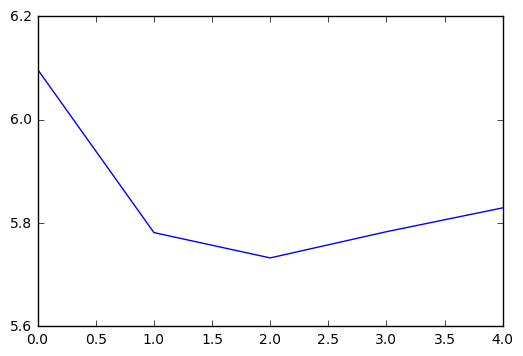

In [170]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    
show_plot(plot_losses)

In [171]:
def evaluate(sentence, max_length=MAX_LENGTH):
    input_variable = variable_from_sentence(articleCaptionLang, sentence)
    input_length = input_variable.size()[0]
    
    # Run through encoder
    encoder_hidden = encoder.init_hidden()
    encoder_outputs, encoder_hidden = encoder(input_variable, encoder_hidden)

    # Create starting vectors for decoder
    decoder_input = Variable(torch.LongTensor([[articleCaptionLang.word2index['[SOS]']]])) # SOS
    decoder_context = Variable(torch.zeros(1, decoder.hidden_size))
    if USE_CUDA:
        decoder_input = decoder_input.cuda()
        decoder_context = decoder_context.cuda()

    decoder_hidden = encoder_hidden
    
    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)
    
    # Run through decoder
    for di in range(max_length):
        decoder_output, decoder_context, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_context, decoder_hidden, encoder_outputs)
#         decoder_attentions[di,:decoder_attention.size(2)] += decoder_attention.squeeze(0).squeeze(0).cpu().data

        # Choose top word from output
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == articleCaptionLang.word2index['[EOS]']:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(articleCaptionLang.index2word[ni])
            
        # Next input is chosen word
        decoder_input = Variable(torch.LongTensor([[ni]]))
        if USE_CUDA: decoder_input = decoder_input.cuda()
    
    return decoded_words, decoder_attentions[:di+1, :len(encoder_outputs)]

In [172]:
def evaluate_randomly():
    pair = random.choice(pairs)
    
    output_words, decoder_attn = evaluate(pair[0])
    output_sentence = ' '.join(output_words)
    
    print('>', pair[0])
    print('=', pair[1])
    print('<', output_sentence)
    print('')

In [173]:
evaluate_randomly()

> Jean Claude Baby Doc Duvalier the deposed playboy President of Haiti died earlier this month in the Haitian capital of Port au Prince apparently of natural causes. He was . His father Fran ois Papa Doc Duvalier had appointed Jean Claude President for life in at the age of only . Duvalier p re entertained more than an anthropological interest in Afro Caribbean ritual. His wardrobe of black suits and black homburgs lent him the aspect Haitians say of the Vodou divinity Baron Samedi who haunts the graveyards in a top hat and tails like a ghoulish Groucho Marx. Baby Doc was no less unusual a dictator. Having misruled Haiti for years he and his beautiful Haitian wife Mich le Bennett were overthrown in the popular uprising of February and fled first to France then to the United States. Their hurried departure overseas became the subject of Christopher Hope s entertaining novel My Chocolate Redemeer where a deposed Caribbean dictator commandeers two floors of a hotel in the South of France 